
# TP4.1: simple MLP regression in numpy, pytorch-style

# ! Correction !

https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#warm-up-numpy

## Our model (aka the "Student")

Derive the gradient updates for:
\begin{align}
\mathcal{L} = \frac{1}{N} \frac{1}{2}\sum_n (\hat{y}_n-y)^2
\\
\hat{y} = \vec w_3 \cdot ( \sigma(W_2 \sigma( W_1 \vec x + b_1)   +b_2 ) ) +b_3
\end{align}
Where $\hat{y}\in\mathbf{R}, x_n\in \mathbf{R}^D, W_0\in \mathbf{R}^{D_1\times D}$, etc, and  $\sigma$ is a generic activation function, assumed differentiable almost everywhere (ReLU or sigmoid for instance).


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# input data
N=1000
D=13
X = (np.random.random((N,D))-0.5)*3

In [3]:
X.shape, X.min(), X.max(), X.std()

((1000, 13), -1.4998438704076564, 1.499802732479115, 0.8634512628011297)

## Here we use fake data. Do NOT specifically use the same dimensions !!
 Pretend that you don't know where the data comes from

In [5]:
# teacher model:
def teacher(X):
    def ReLU(a):
        ## this is the Heavise, but for arrays:
        out = a.copy()
        out[-a>0]*= 0.0
        return out
    N = X.shape[0]
    D = X.shape[1]
    D1 = 20
    D2 = 30
    np.random.seed(2)
    W1=np.random.random((D1,D))-0.5
    W2=np.random.random((D2,D1))-0.5
    W3=np.random.random((D2))-0.5  ## it could be (1,D2)
    sigma = ReLU
    y = W3 @ sigma( W2@sigma( W1@X.T ) )
    return y

In [6]:
y = teacher(X)
y.shape

(1000,)

In [7]:
def initalize_param(shape):
    sigma = shape[0]**-0.5
    param = np.random.normal(0, sigma, shape)
    return param

In [8]:
def ReLU(a):
    ## this is the Heavise, but for arrays:
    out = a.copy()
    out[-a>0]*= 0.0
    return out

In [9]:
def derivativeOfReLU(a):
    ## this is the Heavise, but for arrays:
    out = a.copy()
    out[-a>0]*= 0.0
    out[a>0] = 1.0
    return out

In [10]:
## you can check it does what you want to:
a = np.random.random((5,7))-0.5  
ReLU(a) , derivativeOfReLU(a)

(array([[-0.        , -0.        , -0.        , -0.        ,  0.05088286,
         -0.        , -0.        ],
        [ 0.4098261 , -0.        ,  0.13836194, -0.        ,  0.42493606,
         -0.        , -0.        ],
        [ 0.49565704,  0.22394346, -0.        ,  0.02820653, -0.        ,
          0.38191081, -0.        ],
        [ 0.1438936 ,  0.45758168,  0.40882877,  0.40049158,  0.16358886,
         -0.        , -0.        ],
        [-0.        ,  0.39359349,  0.20790939, -0.        ,  0.47203348,
          0.00989247, -0.        ]]),
 array([[-0., -0., -0., -0.,  1., -0., -0.],
        [ 1., -0.,  1., -0.,  1., -0., -0.],
        [ 1.,  1., -0.,  1., -0.,  1., -0.],
        [ 1.,  1.,  1.,  1.,  1., -0., -0.],
        [-0.,  1.,  1., -0.,  1.,  1., -0.]]))

In [11]:
### We provide the skeleton of the class, for you to READ here

### But, do not hack it yet !

In [27]:
class model_MLPnumpy():

    def __init__(self, input_size, hidden_layers_sizes, seed=2):
        
        assert(hidden_layers_sizes[-1] == 1)
        
        np.random.seed(seed)
        ## typically in torch the aprameters are not given values, not even instanciated, at init time.
        ## but it's convenient to do it right now in our simple numpy imitation
        hidden_layers_sizes.insert(0, input_size)
        
        self.W1 = initalize_param((hidden_layers_sizes[1],input_size))
        self.b1 = np.zeros((hidden_layers_sizes[1], 1))
        
        self.W2 = initalize_param((hidden_layers_sizes[2],hidden_layers_sizes[1]))
        self.b2 = np.zeros((hidden_layers_sizes[2], 1))
    
        self.W3 = initalize_param((hidden_layers_sizes[3], hidden_layers_sizes[2]))
        self.b3 = np.zeros((hidden_layers_sizes[3], 1))
        
        self.sigma = ReLU
        self.sigprime = derivativeOfReLU
        
        self.costs = []
    
    def forward(self, X):
        x = X.copy()  ## kind of bad practice but easier to read and make sure we don't break stuff

        A0 = x.T
        Z1 = self.W1@A0 + self.b1
        A1 = self.sigma(Z1)
        Z2 = self.W2@A1 + self.b2
        A2 = self.sigma(Z2)
        Z3 = self.W3@A2 + self.b3
        A3 =            Z3
        self.A3, self.Z3, self.A2, self.Z2, self.A1, self.Z1, self.A0 = A3,Z3,A2,Z2,A1,Z1,A0
        return A3

    
    def backward(self, yhat, y): ## only works for MSE loss:
        
        A3,Z3,A2,Z2,A1,Z1,A0 = self.A3, self.Z3, self.A2, self.Z2, self.A1, self.Z1, self.A0
        
        dA3 = (A3-y)  ## dA3 and dZ3 are what they are because of our choice of loss. They will be different for other losses.
        dZ3 = dA3  ## there is no activation function at the end of the regression-network
        dW3 = dZ3 @ A2.T           # (yhat-y @ A2.T)
        db3 = dZ3 @ np.ones((N,1))

        dA2 = self.W3.T @  dZ3  # try out: W3.shape, W3.reshape(-1,1).shape, dZ3.shape
        dZ2 = dA2 * self.sigprime(Z2)  ## point-wise multiplication of matrices of same shape !!
        dW2 = dZ2 @ A1.T             # (W3.T @ (yhat-y) * sigmaprime(Z2) ) @ A1.T
        db2 = dZ2 @ np.ones((N,1))   # (W3.T @ (yhat-y) * sigmaprime(Z2) ) @ ones(N,1)

        dA1 = self.W2.T @ dZ2          
        dZ1 = dA1 * self.sigprime(Z1) ## point-wise multiplication of matrices of same shape !!
        dW1 = dZ1 @ A0.T
        db1 = dZ1 @ np.ones((N,1))
        
    
        (self.db1, self.dW1, self.db2, self.dW2, self.db3, self.dW3) = (db1, dW1, db2, dW2, db3, dW3)
#         return gradients
        
    def step(self, eta, Nbatch):
        n = Nbatch

        self.b1 -= eta/n*self.db1
        self.W1 -= eta/n*self.dW1
        self.b2 -= eta/n*self.db2
        self.W2 -= eta/n*self.dW2
        self.b3 -= eta/n*self.db3
        self.W3 -= eta/n*self.dW3
       
    def loss(self, output, Y):
        return np.mean((output-Y)**2)
    
    def fit(self, X, Y, eta=0.01, n_iterations=500):
        Nbatch = X.shape[0] ## full batch for now
        for loop in range(n_iterations):
            out = self.forward(X)
            cost = self.loss(out, Y) ##book-keeping
            self.backward(out, Y)
            self.step(eta, Nbatch=Nbatch)
        
            if loop % 100 == 0:
                print("Cost: ", cost)

            if loop % 10 == 0:
                self.costs.append(cost) 

In [28]:
self = model_MLPnumpy(D, [35,30,1], seed=3)
self.fit(X,y, eta=0.03)

Cost:  2.8360783206818088
Cost:  0.18679848424037113
Cost:  0.11260894568096734
Cost:  0.084549286438194
Cost:  0.0707279076136316


[]

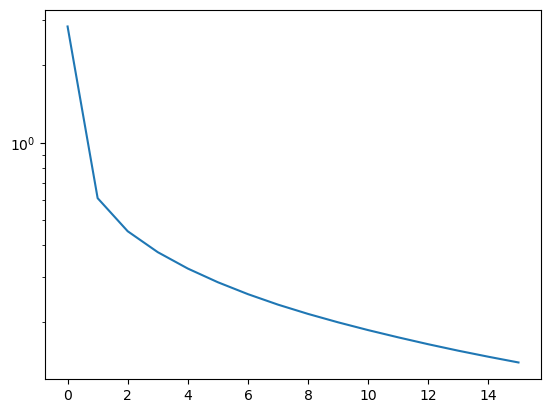

In [30]:
plt.plot(self.costs)
plt.semilogy()

In [31]:
ypred = self.forward(X)
plt.scatter(y, y)
plt.scatter(ypred, y)
self.loss(ypred, y)

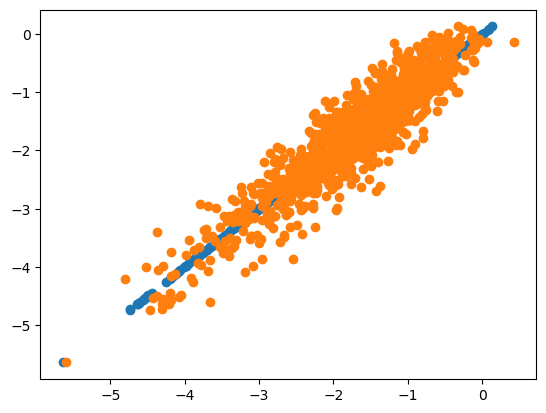

## same, but run for longer:

In [33]:
self = model_MLPnumpy(D, [35,30,1], seed=3)
self.fit(X,y, eta=0.03, n_iterations=2000)

Cost:  2.8360783206818088
Cost:  0.18679848424037113
Cost:  0.11260894568096734
Cost:  0.084549286438194
Cost:  0.0707279076136316
Cost:  0.061774849328103155
Cost:  0.05546561389135947
Cost:  0.05053870040368796
Cost:  0.04647984718435072
Cost:  0.04298496938972524
Cost:  0.03996194985446298
Cost:  0.03748918575294404
Cost:  0.03541763813928009
Cost:  0.03364196306426515
Cost:  0.031973828660602645
Cost:  0.030503745383778563
Cost:  0.029164768089594603
Cost:  0.02797216439623513
Cost:  0.026857737975202696
Cost:  0.025863615531361538


[]

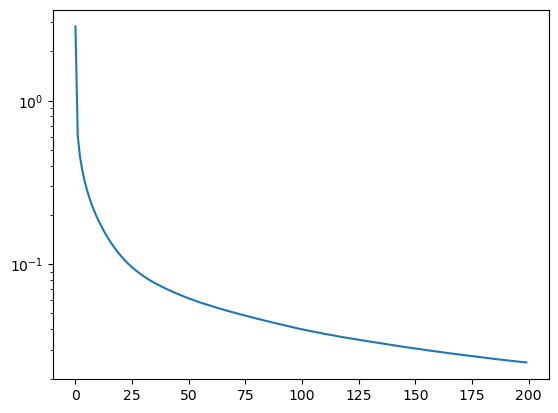

In [34]:
plt.plot(self.costs)
plt.semilogy()

0.024981034464477782

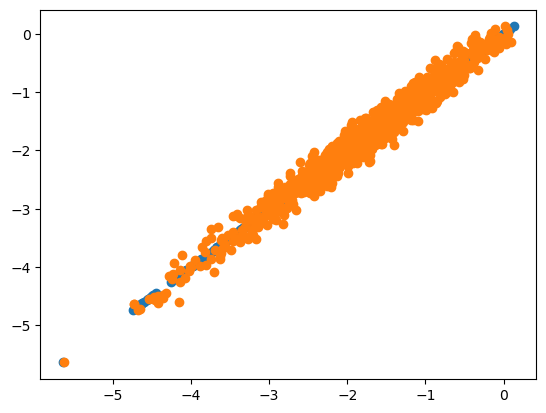

In [35]:
ypred = self.forward(X)
plt.scatter(y, y)
plt.scatter(ypred, y)
self.loss(ypred, y)

In [17]:
self.W3.shape, self.W2.shape, self.W1.shape

((1, 30), (30, 35), (35, 13))

In [18]:
W1,b1,W2,b2,W3,b3, = self.W1, self.b1, self.W2, self.b2, self.W3, self.b3
A3,Z3,A2,Z2,A1,Z1,A0 = self.A3, self.Z3, self.A2, self.Z2, self.A1, self.Z1, self.A0

In [20]:
A3 = self.forward(X)